# OxCrest

A program to generate images of Oxford college crests based on a text prompt.

The model has been trained using the college crests of the 44 Oxford colleges.  

**References**

[Oxford college crests by *The Oxbridge Pursuviant*](https://theoxbridgepursuivant.blogspot.com/2015/11/heraldry-cumulative-posts-by-date-of.html)

[DreamBooth training example provided by *HackCambridge*](https://drive.google.com/file/d/1oGjBHkWdtJg6Vfvd9VhDF_mYPFYgWg7d/view?usp=sharing)

[Blogpost for Controlnet by *lllyasviel*](https://huggingface.co/lllyasviel/sd-controlnet-scribble)

In [1]:
!git clone https://github.com/shinben0327/CambridgeSpyderLite.git

Cloning into 'CambridgeSpyderLite'...
remote: Enumerating objects: 124, done.
remote: Counting objects: 100% (85/85), done.
remote: Compressing objects: 100% (80/80), done.
remote: Total 124 (delta 9), reused 73 (delta 4), pack-reused 39
Receiving objects: 100% (124/124), 46.72 MiB | 18.04 MiB/s, done.
Resolving deltas: 100% (17/17), done.


# Initialise environment
* Install necessary packages and libraries
* Login with huggingface token and prepare accelerate configurations

In [2]:
# Check GPU is available
!nvidia-smi --query-gpu=name,memory.total,memory.free --format=csv,noheader

Tesla T4, 15360 MiB, 15101 MiB


In [3]:
# Install necessary packages
!wget -q https://github.com/huggingface/diffusers/raw/main/examples/dreambooth/train_dreambooth.py
%pip install -qq git+https://github.com/huggingface/diffusers.git
%pip install -q -U --pre triton
%pip install -q accelerate transformers ftfy xformers bitsandbytes==0.35.0

!pip install -q diffusers==0.14.0 transformers xformers git+https://github.com/huggingface/accelerate.git
!pip install -q opencv-contrib-python
!pip install -q controlnet_aux

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.2/199.2 KB 7.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.3/63.3 MB 10.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 145.0/145.0 KB 17.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.8/212.8 KB 8.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 70.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.1/53.1 KB 6.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.9/50.9 MB 19.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.5/62.5 MB 12.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 106.8 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing

In [5]:
# Enter your huggingface token for model access
from huggingface_hub import notebook_login
notebook_login()

Token is valid.
Your token has been saved in your configured git credential helpers (store).
Your token has been saved to /root/.cache/huggingface/token
Login successful


In [6]:
# Create a default accelerate config
from accelerate.utils import write_basic_config
write_basic_config()

# Ensure that your accelerate config looks ok
!accelerate env

2023-03-12 18:35:22.025613: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/lib64-nvidia
2023-03-12 18:35:22.025745: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/lib64-nvidia
2023-03-12 18:35:22.025771: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are installed properly.

Copy-and-paste the text below in your GitHub issue

- `Accelerate` version: 0.18.0.dev0
- Platform: Linux-5.10.147+-x86_64-with-glibc2.31
- Python version: 3.9.16
- N

In [7]:
# Import necessary libraries
from diffusers import StableDiffusionPipeline
import torch

from PIL import Image
from diffusers import StableDiffusionControlNetPipeline, ControlNetModel, UniPCMultistepScheduler
import torch
from controlnet_aux import HEDdetector
from diffusers.utils import load_image

import cv2 as cv
import numpy as np

# Model Preparation
* Import training image dataset
* Train the model

In [8]:
# Save a folder with your chosen images
!rm -r CambridgeSpyderLite
!git clone https://github.com/shinben0327/CambridgeSpyderLite.git

Cloning into 'CambridgeSpyderLite'...
remote: Enumerating objects: 124, done.
remote: Counting objects: 100% (85/85), done.
remote: Compressing objects: 100% (80/80), done.
remote: Total 124 (delta 9), reused 73 (delta 4), pack-reused 39
Receiving objects: 100% (124/124), 46.72 MiB | 33.95 MiB/s, done.
Resolving deltas: 100% (17/17), done.


In [9]:
# Define the model name and image/output paths
MODEL_NAME="CompVis/stable-diffusion-v1-4"
INSTANCE_DIR="/content/CambridgeSpyderLite/crests"
OUTPUT_DIR="/content/model_weights"

In [10]:
# Train the model based on the crest image dataset
!accelerate launch train_dreambooth.py \
  --pretrained_model_name_or_path=$MODEL_NAME  \
  --instance_data_dir=$INSTANCE_DIR \
  --output_dir=$OUTPUT_DIR \
  --instance_prompt="a photo of oxford college crest" \
  --resolution=512 \
  --train_batch_size=1 \
  --gradient_accumulation_steps=1 --gradient_checkpointing \
  --use_8bit_adam \
  --learning_rate=5e-6 \
  --lr_scheduler="constant" \
  --lr_warmup_steps=0 \
  --max_train_steps=10 \
  --enable_xformers_memory_efficient_attention

2023-03-12 18:35:41.361817: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/lib/python3.9/dist-packages/cv2/../../lib64:/usr/lib64-nvidia
2023-03-12 18:35:41.361934: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/lib/python3.9/dist-packages/cv2/../../lib64:/usr/lib64-nvidia
2023-03-12 18:35:41.361953: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are installed properly.
The following values were not passed to `accelerate launc

# Generate a crest
* Create a stable diffusion pipeline
* Generate the image and visualise

In [11]:
# Create stable diffusion pipeline 
pipe = StableDiffusionPipeline.from_pretrained(
    MODEL_NAME, torch_dtype=torch.float16
    ).to("cuda")

Fetching 16 files:   0%|          | 0/16 [00:00<?, ?it/s]

/usr/local/lib/python3.9/dist-packages/transformers/models/clip/feature_extraction_clip.py:28: FutureWarning: The class CLIPFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use CLIPImageProcessor instead.
  warnings.warn(


In [12]:
# Generate image based on the pipeline
prompt = "a photo of an oxford college crest that includes a cat"
guidance_scale = 55 
generated_image = pipe(prompt, num_inference_steps=55, guidance_scale=guidance_scale).images[0]

  0%|          | 0/55 [00:00<?, ?it/s]

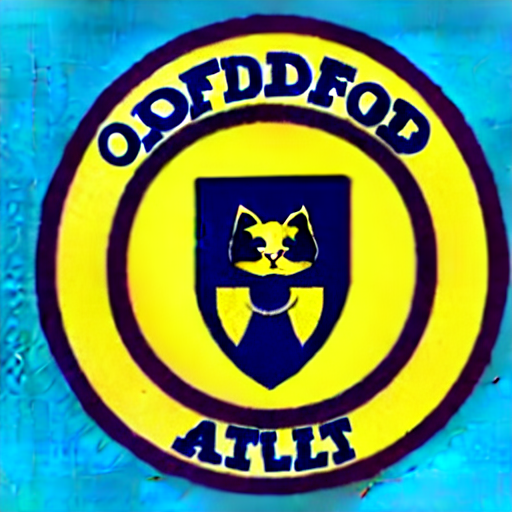

In [13]:
# Show the generated image
generated_image

In [14]:
# Optional: Generate multiple images with varying guidance_scale settings

# !mkdir result_image
# for n in range(5, 80, 5):
#   for i in range(5):
#     image = pipe(prompt, num_inference_steps=50, guidance_scale=n).images[0]
#     image.save('result_images/crest_out_' + str(n) + '_' + str(i) + '.png')
# !zip -r /content/result_images.zip /content/result_images

# Generate a crest with border
* Create a stable diffusion pipeline with a Controlnet to guide the shape of the generated image
* Generate the image and visualise
* Mask the image to fit the shield-like shape of a college crest


In [16]:
# Import the shield-like shape of a college crest
crest_outline = load_image("https://github.com/shinben0327/CambridgeSpyderLite/blob/main/crest_outline.png?raw=true")
image = crest_outline

# Create stable diffusion pipeline with scribble border Controlnet
controlnet = ControlNetModel.from_pretrained(
    "fusing/stable-diffusion-v1-5-controlnet-scribble", torch_dtype=torch.float16
)

pipe = StableDiffusionControlNetPipeline.from_pretrained(
    MODEL_NAME, controlnet=controlnet, safety_checker=None, torch_dtype=torch.float16
)
pipe.scheduler = UniPCMultistepScheduler.from_config(pipe.scheduler.config)
pipe.enable_model_cpu_offload()

Fetching 16 files:   0%|          | 0/16 [00:00<?, ?it/s]

/usr/local/lib/python3.9/dist-packages/transformers/models/clip/feature_extraction_clip.py:28: FutureWarning: The class CLIPFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use CLIPImageProcessor instead.
  warnings.warn(
You have disabled the safety checker for <class 'diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion_controlnet.StableDiffusionControlNetPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .


In [17]:
# Generate image
generated_image = pipe("a photo of an oxford college crest that includes a symbol of a cat", image, num_inference_steps=20).images[0]

  0%|          | 0/20 [00:00<?, ?it/s]

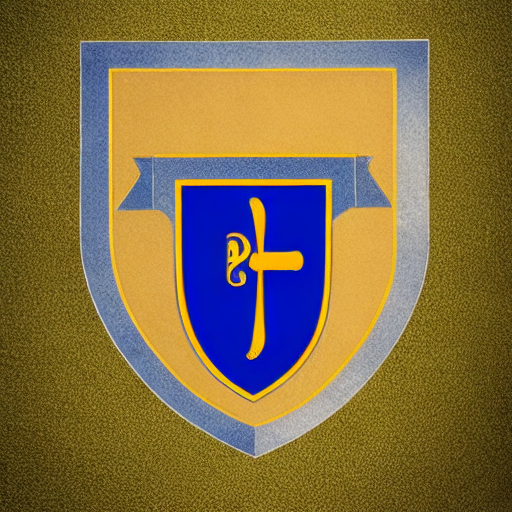

In [18]:
# Show the generated image
generated_image

In [19]:
# Mask the image to remove the background of the image
mask = load_image("https://github.com/shinben0327/CambridgeSpyderLite/blob/main/crest_mask.png?raw=true")
mask.save('mask.png')
generated_image.save('image.png')

cv_mask = cv.imread('mask.png')
cv_image = cv.imread('image.png')

masked = cv.bitwise_and(cv_image, cv_mask)

cv.imwrite('masked.png', masked)

True

In [20]:
# Optional: Generate multiple images

# !mkdir masked_batch
# for n in range(30):
#   generated_image = pipe("a photo of an oxford college crest that includes a symbol of a cat", image, num_inference_steps=20).images[0]
#   generated_image.save('image.png')
#   cv_image = cv.imread('image.png')
#   masked = cv.bitwise_and(cv_image, cv_mask)
#   filename_masked = 'masked_batch/' + 'masked' + str(n).zfill(2) + '.png'
#   cv.imwrite(filename_masked, masked)
# !zip -r /content/file.zip /content/masked_batch

# Additional trials...

In addition to the crest generation above, an attempt wa made to automate the detection and replacement of Oxford college crests in photos. Specifically, this attmept was focused on pictures of college puffers, which feature each colleges' crest on the left chest region.

In [21]:
!pip install controlnet_aux
!pip install xformers
!pip install diffusers transformers git+https://github.com/huggingface/accelerate.git

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/huggingface/accelerate.git to /tmp/pip-req-build-pi7_075c
  Running command git clone --filter=blob:none --quiet https://github.com/huggingface/accelerate.git /tmp/pip-req-build-pi7_075c
  Resolved https://github.com/huggingface/accelerate.git to commit 37831808444e089a182f66713935d27c39a0cf2c
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [23]:
from PIL import Image
import os
import numpy as np
import cv2 as cv
from diffusers import StableDiffusionControlNetPipeline, ControlNetModel, UniPCMultistepScheduler
import torch
from controlnet_aux import HEDdetector
from diffusers.utils import load_image
from google.colab.patches import cv2_imshow

# Methodologies
The following methods were used in an attempt to pinpoint the location and orientation of the college crest on a photograph.

## HED detector

The HED detector, originally written for the scribble version of the Stable Diffusion Controlnet, takes an input image and outputs a 'scribble' version that vaguely matches the outlines of the photo.

The location of the college crest was manually entered for a first iteration (see cropped image for *puffer1*), as we expected to automate this by future design iterations. This unfortunately did not happen within the time limit of the event.

puffer


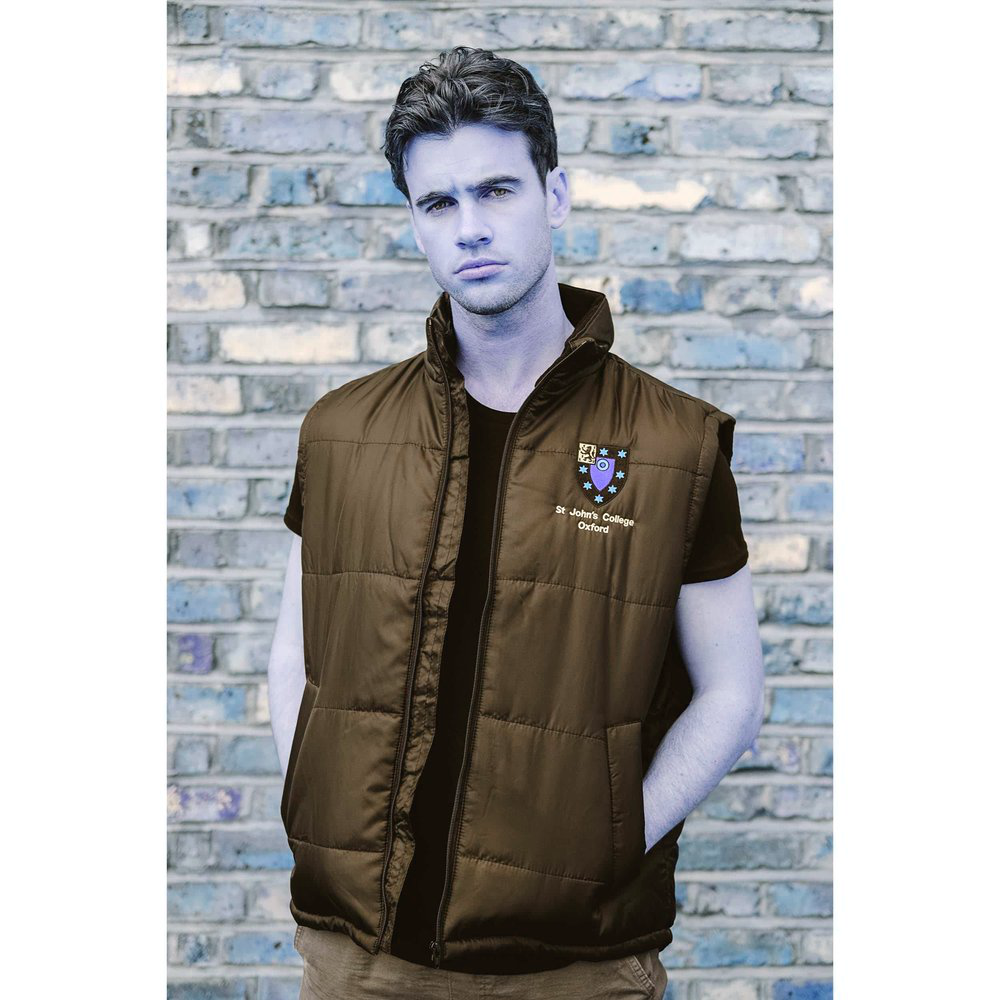

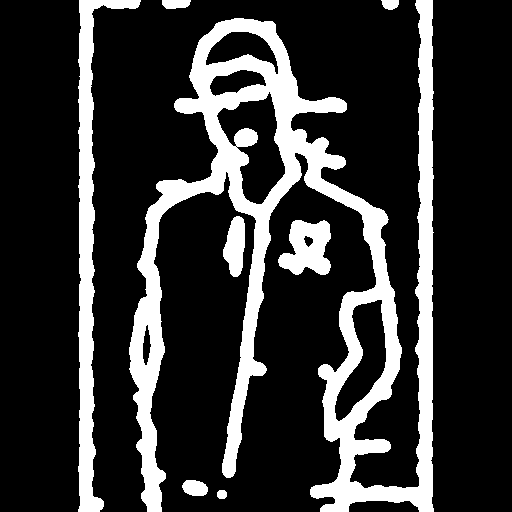

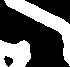

puffer1


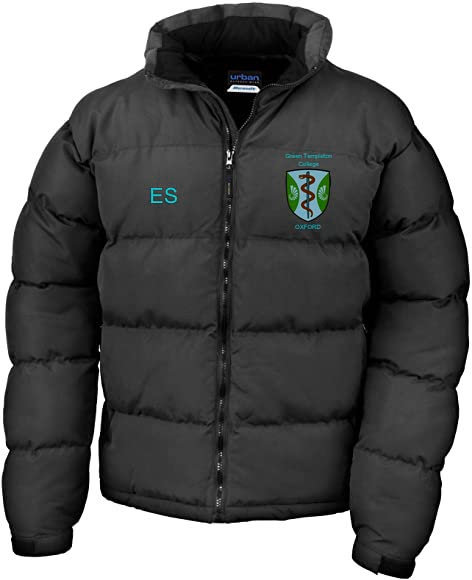

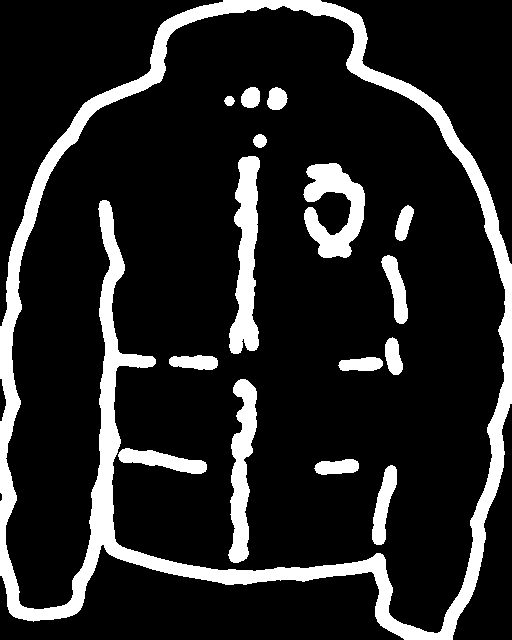

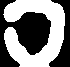

puffer2


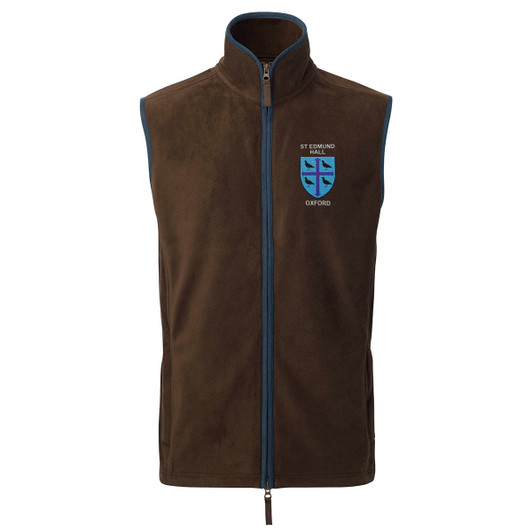

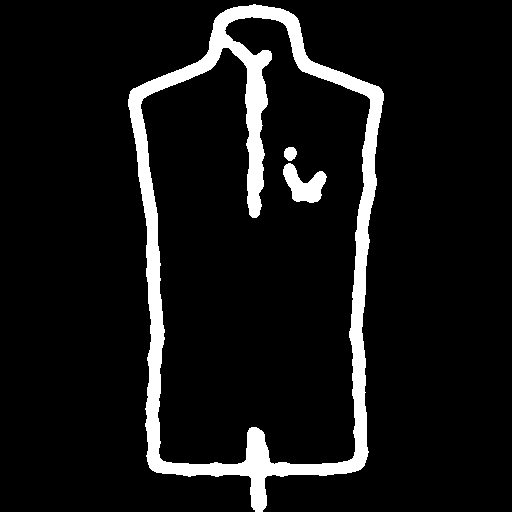

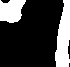

In [24]:
# Declaring HED detector
hed = HEDdetector.from_pretrained('lllyasviel/ControlNet')

image_dir = '/content/CambridgeSpyderLite/images/test/'

for file in os.listdir(image_dir):
  filenamelist = os.path.splitext(file)
  filename = filenamelist[0]
  
  print(filename)
  
  # get image_original(PIL.Image.image)
  image_original = load_image(image_dir+filename+'.jpg')

  # HED Stable Diffusion Control Net
  image = hed(image_original, scribble=True)
  image_crop = image.crop((300,180,370,247))
  
  image.save(os.path.join('/content/CambridgeSpyderLite/images/',filename+'_output.jpeg'))
  image_crop.save(os.path.join('/content/CambridgeSpyderLite/images/',filename+'_crop.jpeg'))

  cv2_imshow(np.asarray(image_original))
  cv2_imshow(np.asarray(image))
  cv2_imshow(np.asarray(image_crop))

## OpenCV Harris Corner Detection

To automatically find the location and orientation of the college crest, the Harris Corner Detection algorithm was used (using OpenCV), as we initially reasoned that the corner coordinates of the college crest would allow us to define two representative lines and apply a transformation matrix to our generated crest.

After implementing the corner detection algorithm, we found that it was not reliable enough in its current state to define two clear lines.

We also attempted to apply the corner detection algorithm to the output of the HED detector, which gave more promising results (see second output photo of each puffer; the red dots are more representative of the outlines). While we were unable to further pursue this method, this could be a continuing point of interest for further development.**bold text**

puffer


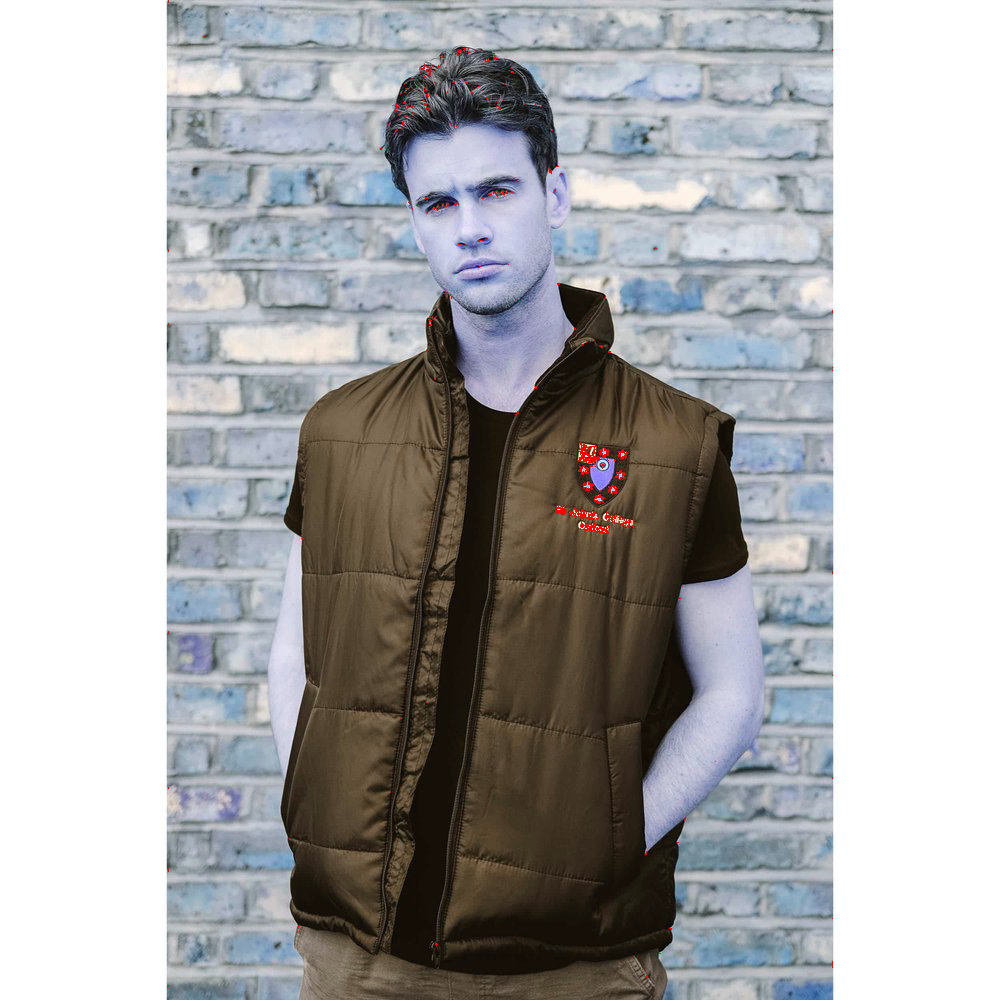

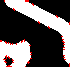

puffer1


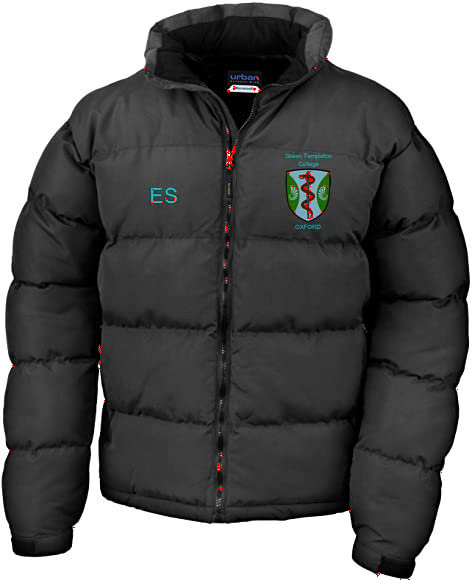

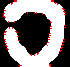

puffer2


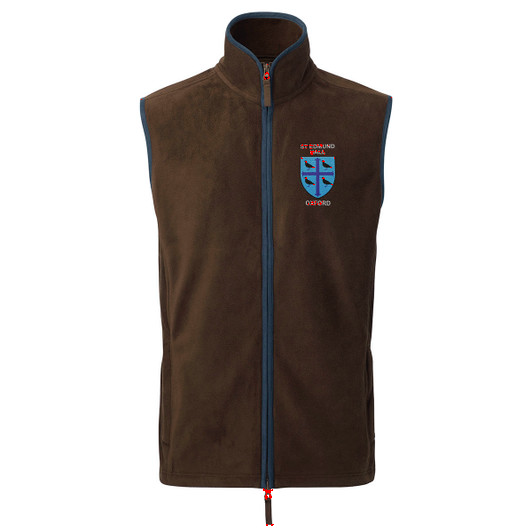

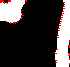

In [25]:
for file in os.listdir(image_dir):
  filenamelist = os.path.splitext(file)
  filename = filenamelist[0]

  print(filename)
  
  image_original = load_image(image_dir+filename+'.jpg')
  image = hed(image_original, scribble=True)
  image_crop = image.crop((300,180,370,247))

  # OpenCV Harris Corner Detection
  image_cv = np.asarray(image_original)
  image_crop_cv = np.asarray(image_crop)

  image_cv_gray = cv.cvtColor(image_cv,cv.COLOR_BGR2GRAY)
  image_crop_cv_gray = cv.cvtColor(image_crop_cv,cv.COLOR_BGR2GRAY)

  dst = cv.cornerHarris(image_cv_gray,2,3,0.04)
  dst_crop = cv.cornerHarris(image_crop_cv_gray,2,3,0.04)

  image_cv[dst>0.01*dst.max()]=[0,0,255]
  cv2_imshow(image_cv)

  image_crop_cv[dst_crop>0.01*dst_crop.max()]=[0,0,255]
  cv2_imshow(image_crop_cv)

  final_output = Image.fromarray(np.uint8(image_crop_cv)).convert('RGB')
  final_output.save('/content/CambridgeSpyderLite/'+filename+'_final.jpeg')
  
  

## Template Matching (attempted)

This method was a last-ditch attempt for a easy way to locate the location and orientation of the college crest. This method involves dilation and template matching of the HED output in order to define the crest location. This method was unfortunately dysfunctional by the end of the allocated time period.

puffer


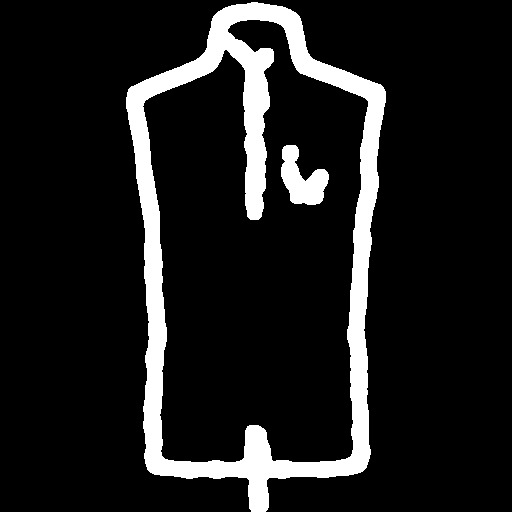

<class 'numpy.ndarray'>


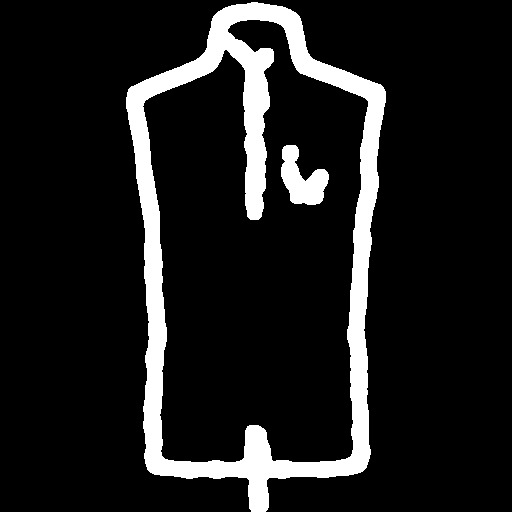

puffer1


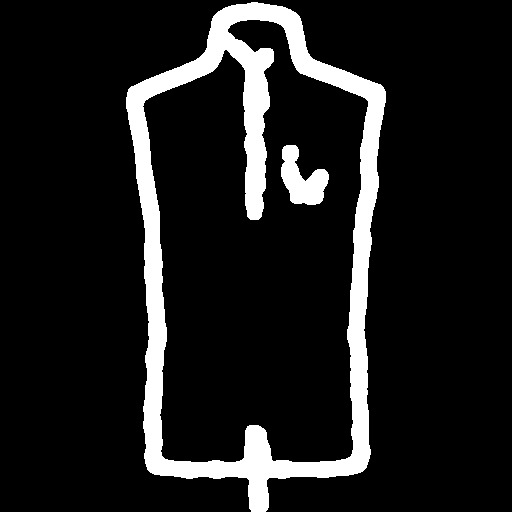

<class 'numpy.ndarray'>


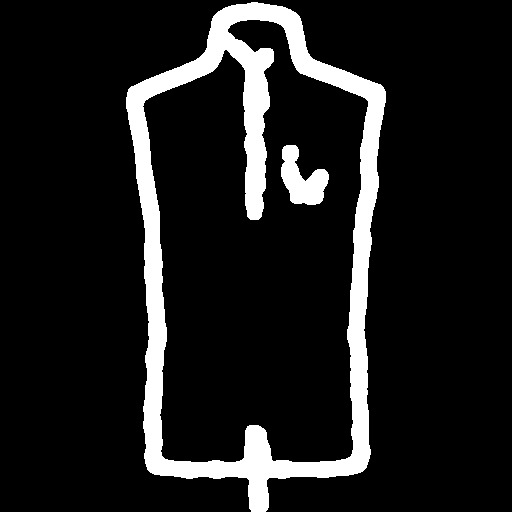

puffer2


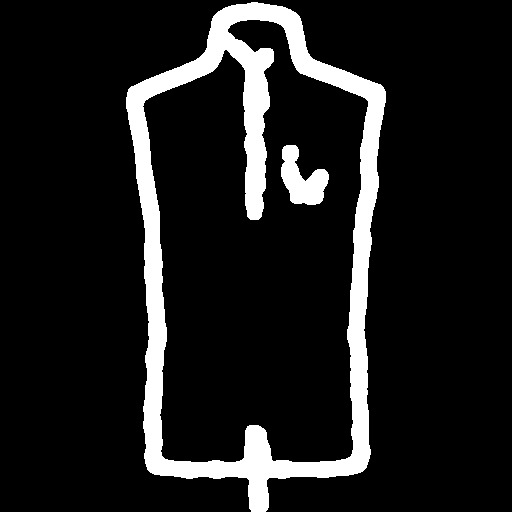

<class 'numpy.ndarray'>


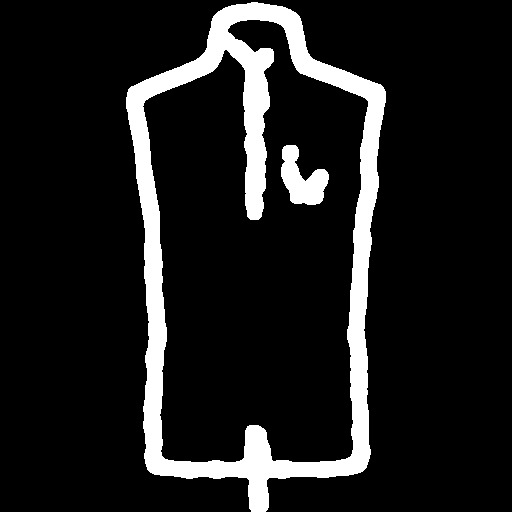

In [26]:
for file in os.listdir(image_dir):
  filenamelist = os.path.splitext(file)
  filename = filenamelist[0]

  print(filename)
  
  image = hed(image_original, scribble=True)

  # (attempted) Template Matching
  kernel = np.ones((5, 5), np.uint8)
  dst_no_dilate = cv.cvtColor(np.asarray(image),cv.COLOR_BGR2GRAY)
  dst_dilate_rgb = cv.dilate(np.asarray(image), kernel, iterations=1)
  dst_dilate = cv.cvtColor(dst_dilate_rgb,cv.COLOR_BGR2GRAY)
  cv2_imshow(dst_dilate)

  template_rgb = cv.imread('/content/CambridgeSpyderLite/images/template/crest_outline.jpg',)
  template = cv.cvtColor(template_rgb, cv.COLOR_BGR2GRAY)
  print(type(template))
  width, height = template.shape
  
  res = cv.matchTemplate(dst_no_dilate, template, cv.TM_CCOEFF_NORMED)
  threshold = 0.5

  loc = np.where(res >= threshold)
  for pt in zip(*loc[::-1]):
    cv.rectangle(dst_dilate, pt, (pt[0] + width, pt[1] + height), (0, 255, 255), 2)
  cv2_imshow(dst_dilate)
